In [77]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind

In [78]:
DATA_FOLDER = "..\data\coged_data_summary"

KEYFILE = "key.csv"
df_key = pd.read_csv("..\data\{}".format(KEYFILE))

In [79]:
list_of_dfs = []
for file in os.listdir(DATA_FOLDER):
    if "_egv4_summary_" in file:
        filename = os.path.join(DATA_FOLDER, file)
        list_of_dfs.append(pd.read_csv(filename, sep="\t"))

df = pd.concat(list_of_dfs)

In [100]:
def tweak_key(df):
    return(df
           .drop(df.index[df.ID == 2018])
           .assign(ID=lambda df_: df_.ID.astype(str))
           .melt(id_vars="ID")
           .rename(columns={"variable": "session",
                            "value": "condition"})
           .assign(session=lambda df_: df_.session.astype("category"),
                   condition=lambda df_: df_.condition.astype("category"))
          )
    
def assemble_df(folder):
    list_of_dfs = []
    for file in os.listdir(folder):
        if "_egv4_summary_" in file:
            filename = os.path.join(folder, file)
            list_of_dfs.append(pd.read_csv(filename, sep="\t"))

    return pd.concat(list_of_dfs)

def tweak_coged(df, key):
    IDs = key.ID.unique()
    
    return (df
            .rename(columns={"script.subjectid": "ID",
                             "script.startdate": "date"},)
            .rename(columns=lambda col: col.replace("values.dprime_", ""))
            .rename(columns=lambda col: col.replace("values.IP", "IP"))
            .rename(columns=lambda col: col.replace("values.winAmount", "win"))
            .replace("values.dprime_")
            .assign(ID=lambda df_: df_.ID.astype(str))
            .assign(ID=lambda df_: np.where(df_["script.groupid"] == 612386580, "9017", df_.ID))
            .assign(ID=lambda df_: np.where(df_["script.groupid"] == 906284594, "9377", df_.ID))
            .query("ID in @IDs")
            .sort_values(by=["ID", "date"])
            .astype({"ID":"category"})
            .assign(n_sessions=lambda df_: df_
                    .groupby("ID")
                    .transform("size"))
            .query("n_sessions == 3")
            .assign(session=lambda df_: len(df_.ID.unique()) * ["T1", "T2", "T3"])
            .merge(key)

            # .reset_index(drop=True) 
           )

DATA_FOLDER = "..\data\coged_data_summary"

KEYFILE = "key.csv"
df_key = pd.read_csv("..\data\{}".format(KEYFILE))
key = tweak_key(df_key)

coged = tweak_coged(assemble_df(DATA_FOLDER), key)

In [101]:
coged.columns


Index(['date', 'script.starttime', 'ID', 'script.groupid',
       'script.elapsedtime', 'computer.platform', 'values.completed', 'IP12',
       'IP13', 'IP14', 'IP15', 'IP16', 'win12', 'win13', 'win14', 'win15',
       'win16', 'winTotal', 'values.hitrate_N2', 'values.zh_N2',
       'values.FArate_N2', 'values.zFA_N2', 'N2', 'values.hitrate_N3',
       'values.zh_N3', 'values.FArate_N3', 'values.zFA_N3', 'N3',
       'values.hitrate_N4', 'values.zh_N4', 'values.FArate_N4',
       'values.zFA_N4', 'N4', 'values.hitrate_N5', 'values.zh_N5',
       'values.FArate_N5', 'values.zFA_N5', 'N5', 'values.hitrate_N6',
       'values.zh_N6', 'values.FArate_N6', 'values.zFA_N6', 'N6', 'n_sessions',
       'session', 'condition'],
      dtype='object')

In [109]:
print("There are {} unique IDs in the dataframe".format(len(coged.ID.unique())))

There are 61 unique IDs in the dataframe


In [75]:
coged.columns

Index(['date', 'script.starttime', 'ID', 'script.groupid',
       'script.elapsedtime', 'computer.platform', 'values.completed',
       'values.IP12', 'values.IP13', 'values.IP14', 'values.IP15',
       'values.IP16', 'values.winAmount12', 'values.winAmount13',
       'values.winAmount14', 'values.winAmount15', 'values.winAmount16',
       'values.winAmountTotal', 'values.hitrate_N2', 'values.zh_N2',
       'values.FArate_N2', 'values.zFA_N2', 'N2', 'values.hitrate_N3',
       'values.zh_N3', 'values.FArate_N3', 'values.zFA_N3', 'N3',
       'values.hitrate_N4', 'values.zh_N4', 'values.FArate_N4',
       'values.zFA_N4', 'N4', 'values.hitrate_N5', 'values.zh_N5',
       'values.FArate_N5', 'values.zFA_N5', 'N5', 'values.hitrate_N6',
       'values.zh_N6', 'values.FArate_N6', 'values.zFA_N6', 'N6', 'n_sessions',
       'session', 'condition'],
      dtype='object')

In [115]:
# saves to csv, may need to reformat for JASP
# dprime
cols = ["ID", "session", "condition", "N2", "N3", "N4", "N5", "N6"]

df_dprime = coged[cols]
df_dprime.to_csv(os.path.join("..//data", "dprime.csv"))

# indifference point
cols = ["ID", "session", "condition", "IP13", "IP14", "IP15", "IP16", ]

df_ip = coged[cols]
df_ip.to_csv(os.path.join("..//data", "ip.csv"))

# win amount
cols = ["ID", "session", "win13", "win14", "win15", "win16", "condition"]

df_win = coged[cols]
df_win.to_csv(os.path.join("..//data", "win.csv"))

In [70]:
conditions = ["CS", "DCS"]
df_dcs = pd.pivot(dprime.query("condition in @conditions"), index="ID", columns=["condition"], values=["N2", "N3", "N4", "N5", "N6"])

In [71]:
df_dcs.dropna()

N2                    N3                    N4            \
condition         CS        DCS         CS        DCS         CS       DCS   
ID                                                                           
2036        6.180012   0.000000   5.746653   4.849651   5.395415  4.288325   
3012       12.000000  12.000000   2.137133   2.273970   6.054519  6.000000   
3048        7.067571   6.967422   7.644854   3.169752   2.800120  2.977296   
4025        7.067571   2.450565   0.618479   0.525648   0.731356  0.894748   
4030       12.000000   7.382994  12.000000   7.949112   2.484076  3.423351   
4035        6.967422   6.565949   1.140635   1.064629   0.525487  2.000404   
4050        7.382994   6.565949   2.525742   1.746322   2.423742  1.278388   
6024        1.563007   7.382994   0.965447   0.892436  -0.364746 -0.273411   
6032       12.000000  12.000000   2.742528   6.804596   1.753280  1.844310   
7024       12.000000  12.000000   3.207955   3.225767   2.313304  2.014528   
7036       12.000000  12.000000   6.712443   6.377392   6.104633  6.164211   
7048       12.000000  12.000000   3.207955   2.888307   2.279978  2.468508   
8014        7.067571   6.967422   7.644854   1.588158   1.745431  2.070552   
8021       12.000000  12.000000  12.000000  12.000000  12.000000  3.071413   
8042        7.067571   6.967422   1.020183   1.636788   1.248451  0.676147   
9034       12.000000   6.967422   1.987498   2.259137   1.566909  1.976106   
9085       12.000000  12.000000   2.099362   3.169752   1.475880  2.684365   
9245       12.000000   7.426077   7.949112   7.252119   3.432953  7.721797   

                 N5                  N6            
condition        CS       DCS        CS       DCS  
ID                                                 
2036       5.091542  5.061186  5.325510  4.309378  
3012       1.743165  1.913884  1.491912  5.434051  
3048       2.183297  6.604585  6.511936  5.945481  
4025       2.558397  0.278210  0.626881  0.859525  
4030       1.688889  1.750934  1.558057  6.391196  
4035       0.561582  0.819234  0.505113  0.907640  
4050       1.271819  1.579206  1.813721  1.250537  
6024       0.844941  0.828374  0.133729  0.715137  
6032       1.429411  1.636274  1.635658  1.330362  
7024       2.024326  2.775928  2.000404  2.249810  
7036       6.348756  6.210428  5.789572  5.488064  
7048       2.153056  2.315050  2.140771  0.993333  
8014       2.000404  2.513506  0.897240  1.657156  
8021       3.432953  2.313304  2.531022  2.313304  
8042       1.515535  0.388070  0.621137  0.744734  
9034       1.429411  1.103025  1.605719  1.236469  
9085       2.293423  2.024326  1.452262  6.604585  
9245       2.851638  2.636728  2.298552  0.908260

N2 Ttest_indResult(statistic=-0.9737603367942151, pvalue=0.3332247512216092)
N3 Ttest_indResult(statistic=-1.3322059602222458, pvalue=0.18672206137388125)
N4 Ttest_indResult(statistic=-0.6311920519820668, pvalue=0.5297842119597657)
N5 Ttest_indResult(statistic=-0.7795101996027267, pvalue=0.4380685974456038)
N6 Ttest_indResult(statistic=1.6307572065671239, pvalue=0.10702550620905371)
N2 Ttest_indResult(statistic=-0.5141755143502841, pvalue=0.6085646460038592)
N3 Ttest_indResult(statistic=-1.6143486967112246, pvalue=0.11043920483715544)
N4 Ttest_indResult(statistic=-1.3507216142816247, pvalue=0.1806409781109068)
N5 Ttest_indResult(statistic=-0.6060331817704891, pvalue=0.5462301210740399)
N6 Ttest_indResult(statistic=-0.13525994516052053, pvalue=0.8927503986758298)


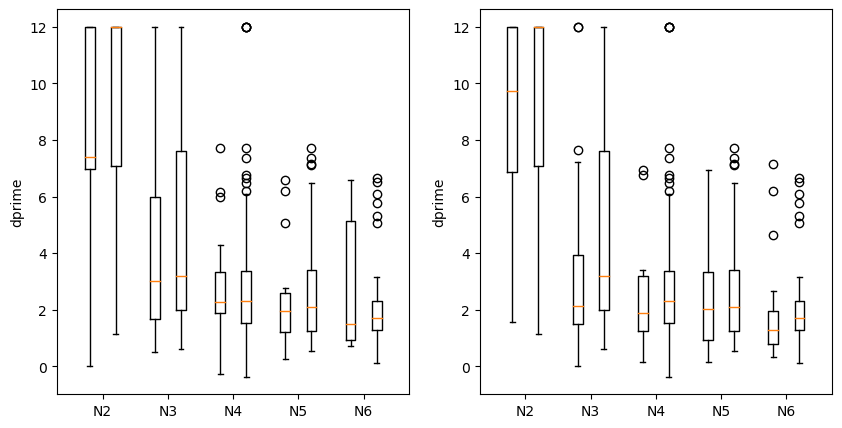

In [120]:
spacing=0.2
nback_levels = ["N2", "N3", "N4", "N5", "N6"]
f, [ax1, ax2] = plt.subplots(figsize=(10,5), ncols=2)

for idx, col in enumerate(nback_levels):
    
    dcs = df_dprime.query("condition == 'DCS'")[col].values
    cs = df_dprime.query("condition == 'CS'")[col].values
    
    ax1.boxplot(dcs, positions=[idx-spacing])
    ax1.boxplot(cs, positions=[idx+spacing])
    
    print(col, ttest_ind(dcs, cs))
    
ax1.set_ylabel("dprime")
ax1.set_xticks(range(5))
ax1.set_xticklabels(nback_levels);

# 
for idx, col in enumerate(nback_levels):
    
    dcs = df_dprime.query("condition == 'CXS'")[col].values
    cs = df_dprime.query("condition == 'CS'")[col].values
    
    ax2.boxplot(dcs, positions=[idx-spacing])
    ax2.boxplot(cs, positions=[idx+spacing])
    
    print(col, ttest_ind(dcs, cs))
    
ax2.set_ylabel("dprime")
ax2.set_xticks(range(5))
ax2.set_xticklabels(nback_levels);

In [22]:


conditions = ["CS", "DCS"]
df_dcs = pd.pivot(df_ip.query("condition in @conditions"), index="ID", columns=["condition"], values=["IP13", "IP14", "IP15", "IP16"]).dropna()

IP13 Ttest_indResult(statistic=-0.47155037738821465, pvalue=0.6385811845823125)
IP14 Ttest_indResult(statistic=-0.6814203466671467, pvalue=0.49764991965175687)
IP15 Ttest_indResult(statistic=-1.1979760109607733, pvalue=0.2346008900270686)
IP16 Ttest_indResult(statistic=-2.3362155667188578, pvalue=0.022083214356177445)


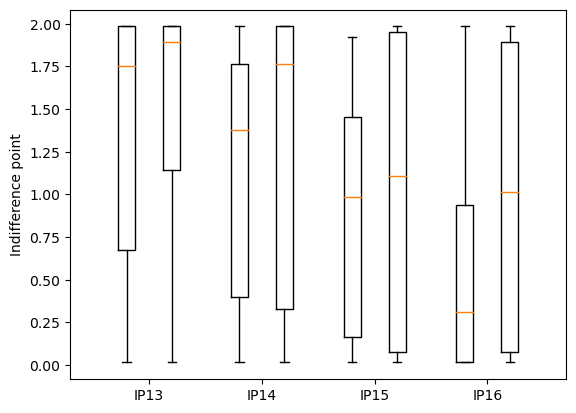

In [86]:
spacing=0.2
nback_levels = ["IP13", "IP14", "IP15", "IP16"]
f, ax = plt.subplots()

for idx, col in enumerate(nback_levels):
    
    dcs = df_ip.query("condition == 'DCS'")[col].values
    cs = df_ip.query("condition == 'CS'")[col].values
    
    ax.boxplot(dcs, positions=[idx-spacing])
    ax.boxplot(cs, positions=[idx+spacing])
    
    print(col, ttest_ind(dcs, cs))
    
ax.set_ylabel("Indifference point")
ax.set_xticks(range(4))
ax.set_xticklabels(nback_levels);

win13 Ttest_indResult(statistic=-0.713750790248319, pvalue=0.47753921329064386)
win14 Ttest_indResult(statistic=-0.8366879028035468, pvalue=0.40535720477172454)
win15 Ttest_indResult(statistic=-1.0337448652217949, pvalue=0.30449131772113686)
win16 Ttest_indResult(statistic=-1.5112124609372335, pvalue=0.1348276057064811)


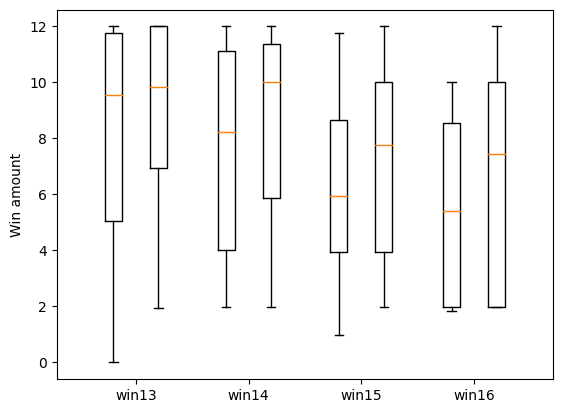

In [90]:
spacing=0.2
nback_levels = ["win13", "win14", "win15", "win16"]
f, ax = plt.subplots()

for idx, col in enumerate(nback_levels):
    
    dcs = df_win.query("condition == 'DCS'")[col].values
    cs = df_win.query("condition == 'CS'")[col].values
    
    ax.boxplot(dcs, positions=[idx-spacing])
    ax.boxplot(cs, positions=[idx+spacing])
    
    print(col, ttest_ind(dcs, cs))
    
ax.set_ylabel("Win amount")
ax.set_xticks(range(4))
ax.set_xticklabels(nback_levels);